# Generating AI images from input

First step here is to generate a variety of AI images from an input. This will be both in-painting and img2img generation, largely done using flux.

NB: This is a dev notebook, with methods to be pulled out into the package.

In [5]:
# collect image and mask pairs
from glob import glob

mask_image = glob("../images/*mask.jpg")
data = []
for mask in mask_image:
    image = mask.replace("_mask", "")
    data.append({"original": image, "mask": mask})

### In-painting

First lets have a look at how to generate in-painted images, using the huggingface `diffusers` library.

In [3]:
import torch
from diffusers import AutoPipelineForInpainting

inpaint_pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
inpaint_pipeline.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


StableDiffusionXLInpaintPipeline {
  "_class_name": "StableDiffusionXLInpaintPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": false,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
# load and resize images and masks for manipulation
from diffusers.utils import load_image


def get_resize_tuple(pil_image, target_size=1024):
    """Calculate resize dimensions based on aspect ratio

    Args:
        pil_image: input image
        target_size: target resize. Defaults to 1024.
    """
    if pil_image.size[0] < pil_image.size[1]:
        # Portrait orientation
        resize_tuple = (
            target_size,
            int(target_size * pil_image.size[1] / pil_image.size[0]),
        )
    else:
        # Landscape orientation
        resize_tuple = (
            int(target_size * pil_image.size[0] / pil_image.size[1]),
            target_size,
        )

    # check it is divisible by 8 and return
    return (
        resize_tuple[0] - resize_tuple[0] % 8,
        resize_tuple[1] - resize_tuple[1] % 8,
    )


def centre_crop(image, new_width, new_height):
    """Perform a centre crop on an input image

    Args:
        image: input image
        new_width: new width to crop to
        new_height: new height to crop to
    """
    width, height = image.size
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2

    return image.crop((left, top, right, bottom))


def resize_and_crop(pil_image, target_size=1024):
    """Resize and crop and image for purposes of AI manipulation

    Args:
        pil_image: input image
        target_size: target resize. Defaults to 1024.
    """
    resize_tuple = get_resize_tuple(pil_image, target_size=target_size)
    pil_image = pil_image.resize(resize_tuple)
    return centre_crop(pil_image, target_size, target_size)

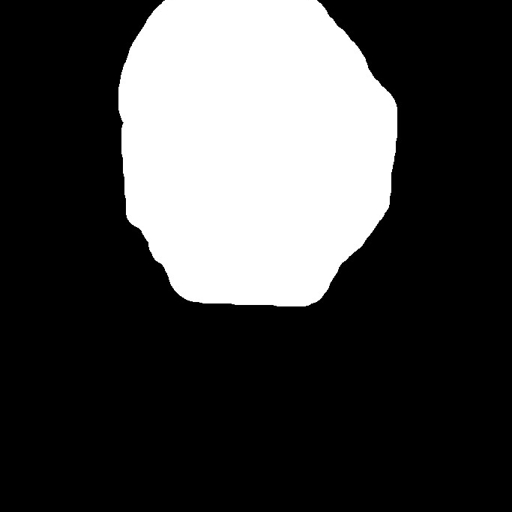

In [7]:
img_path = data[2]
mask = load_image(img_path["mask"])
mask = resize_and_crop(mask, target_size=512)
mask = mask.convert("L")
mask

Lets try this with a picture of me and a random mask

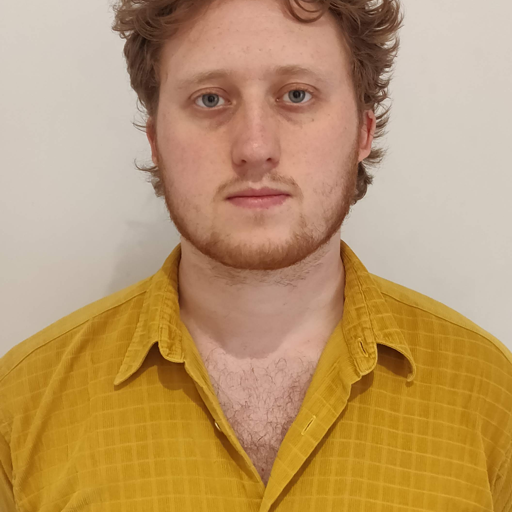

In [8]:
me_img = load_image("../images/me.jpg")
me_img = resize_and_crop(me_img, target_size=512)
me_img

  0%|          | 0/26 [00:00<?, ?it/s]

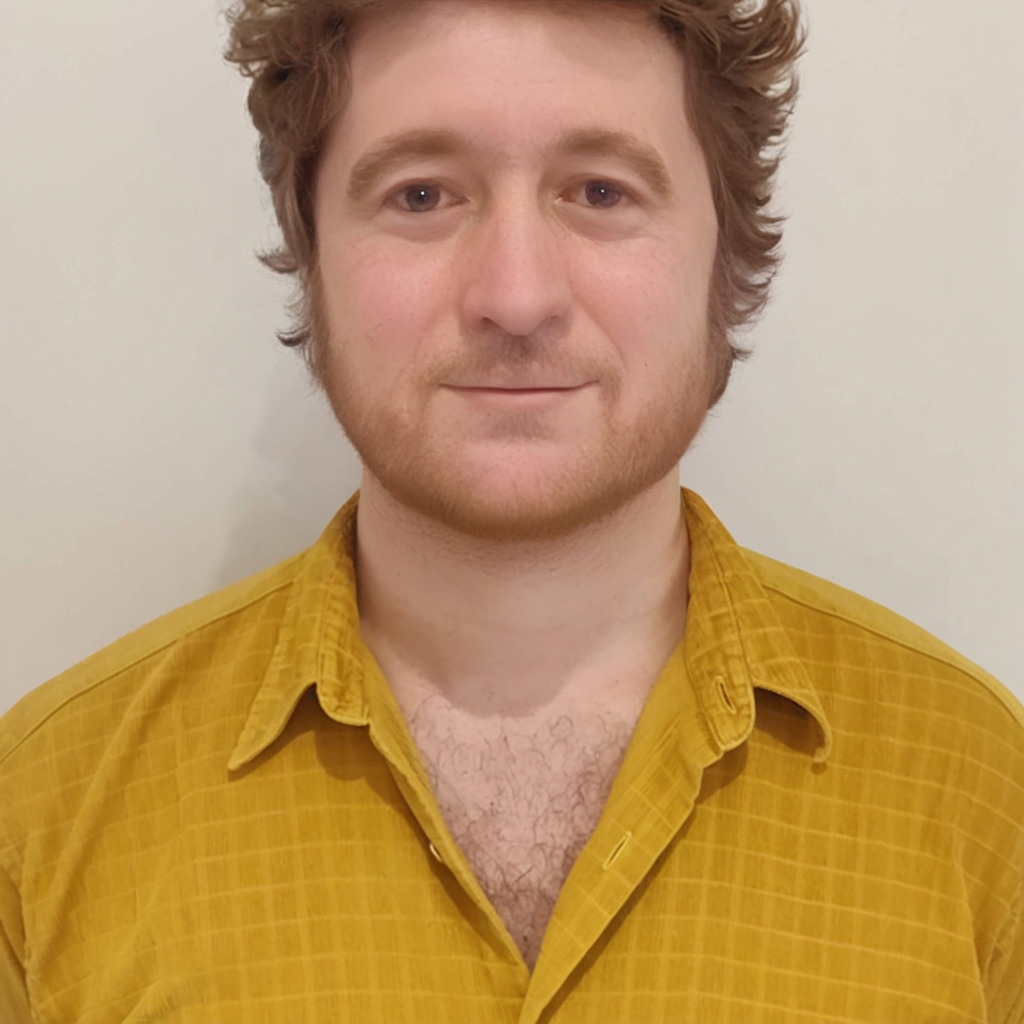

In [10]:
import random

generator = torch.Generator(device=device)

prompt = "a portrait"
inpaint_me_image = inpaint_pipeline(
    prompt=prompt,
    device=device,
    image=me_img,
    mask_image=mask,
    guidance_scale=4.5,
    strength=random.uniform(0.5, 0.89),
    num_inference_steps=40,
    safety_checker=None,
    generator=generator,
).images[0]
inpaint_me_image

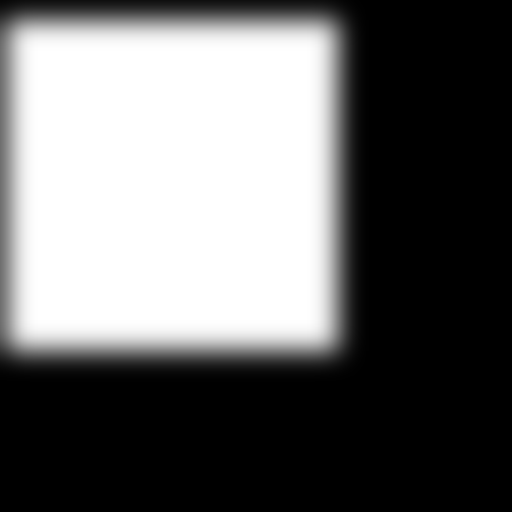

In [21]:
from copy import copy

rand_mask = me_img.copy()
rand_mask = rand_mask.convert("L")
rand_mask = rand_mask.point(lambda x: 0)
blob_size = random.randint(50, 400)
x = random.randint(0, 512 - blob_size)
y = random.randint(0, 512 - blob_size)
for i in range(blob_size):
    for j in range(blob_size):
        rand_mask.putpixel((x + i, y + j), 255)

rand_mask = inpaint_pipeline.mask_processor.blur(rand_mask, blur_factor=12)
rand_mask

  0%|          | 0/59 [00:00<?, ?it/s]

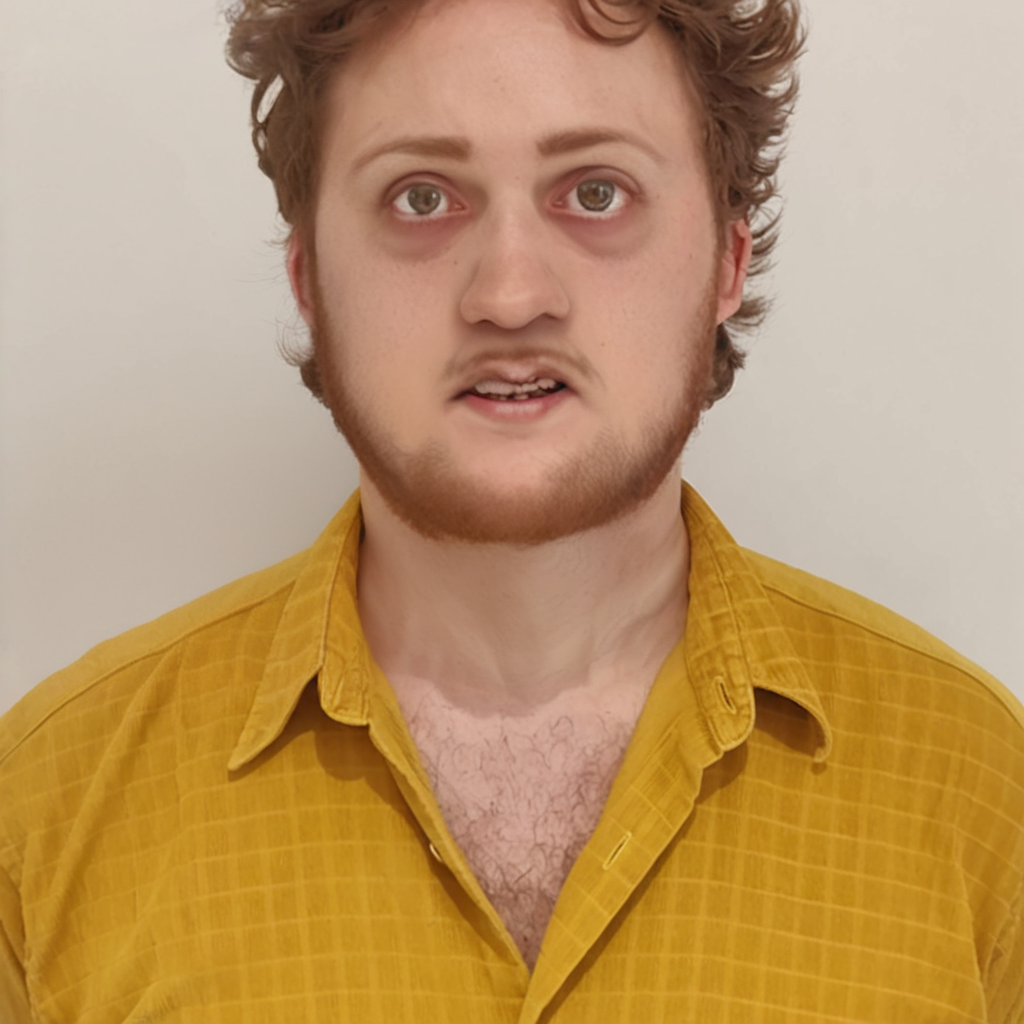

In [22]:
prompt = "a funny, high fantasy picture"
fun_image = inpaint_pipeline(
    prompt=prompt,
    device=device,
    image=me_img,
    mask_image=rand_mask,
    guidance_scale=4.5,
    strength=random.uniform(0.5, 0.89),
    num_inference_steps=100,
    safety_checker=None,
    generator=generator,
).images[0]
fun_image

### Img2Img

Ok, so we've got the inpainting working, what about the img2img?

In [3]:
import torch
from diffusers import FluxImg2ImgPipeline

img2img_pipe = FluxImg2ImgPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import random

prompt = "a high fantasy portrait"
pipe_kwargs = {
    "prompt": prompt,
    "image": me_img,
    "guidance_scale": 2 + random.uniform(0, 5),
    "num_inference_steps": random.randint(10, 25),
    "max_sequence_length": 256,
    "strength": random.uniform(0.2, 0.85),
    "width": me_img.size[0],
    "height": me_img.size[1],
}

out_me_img = img2img_pipe(**pipe_kwargs).images[0]
out_me_img

  0%|          | 0/8 [00:00<?, ?it/s]